# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [ ]:
env = UnityEnvironment(file_name= "C:/projects/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64/Tennis.exe")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
from unityagents import UnityEnvironment

import numpy as np
import random
import torch
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
import time
from tennisagent import Agent
from tennismemory import ReplayBuffer



seed = 777 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_path = "C:/projects/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64/Tennis.exe"  

max_num_episodes = 1000    

memory_capacity = int(1e6)      # Experience replay memory capacity
batch_size = 256             # Batch size: Number of memories will be sampled to learn 

priority_exponent = 0.5         # Prioritised experience replay exponent (originally denoted α)
priority_weight = 0.4           # Initial prioritised experience replay importance sampling weight

random.seed(seed)
torch.manual_seed(random.randint(1, 10000))

torch.cuda.manual_seed(random.randint(1, 10000))

env = UnityEnvironment(file_name = env_path)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Construct the Agent
agent = Agent(state_size=state_size, action_size=action_size, seed = 777)

# Replay memory: We create the Replay Mem outside the Agent so we can share 1 single Mem with two agents. 
memory = ReplayBuffer(action_size, memory_capacity, batch_size, seed)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


C:\ProgramData\Anaconda3\envs\drlnd\lib\site-packages\torch\cuda\__init__.py:114: UserWarning: 
    Found GPU0 Tesla T4 which requires CUDA_VERSION >= 9000 for
     optimal performance and fast startup time, but your PyTorch was compiled
     with CUDA_VERSION 8000. Please install the correct PyTorch binary
     using instructions from http://pytorch.org
    
  warnings.warn(incorrect_binary_warn % (d, name, 9000, CUDA_VERSION))


Function for training the tennis agent.

In [3]:

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def ddpg(agent, memory , StopWhenSolved = True):
    
    best_scores = deque(maxlen=100)
    scores_global = []
    average_global = []
    min_global = []
    max_global = []
    time_taken = 0
    Start_time = time.time()
        
    for i_episode in range(1, agent.max_num_episodes):

        env_info = env.reset(train_mode=True)[brain_name]     	# reset the environment    
        states = env_info.vector_observations                  	# get the current state (for each agent)
        scores = np.zeros(num_agents)                          	# initialize the score (for each agent)
        agent.reset()
        
        timestep = 0
        dones = np.zeros(num_agents) 

        while timestep <= agent.T_max:
            timestep += 1 
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished    
						
            agent.memorize(states, actions, rewards, next_states, dones, memory)
			
            agent.learn(memory,timestep)
						
            states = next_states
            scores += rewards                                    # roll over the state to next time step        
			
			             
                    
        episode_avg_score = np.mean(scores)                
        scores_global.append(episode_avg_score)
                
        min_global.append(np.min(scores))  
        max_global.append(np.max(scores)) 
        
        best_scores.append(max_global[len(max_global)-1])        
        best_scores_average = np.mean(best_scores)
        
        
        print('\rEpisode {} \tlast 100 avg: {:.2f} \tavg score: {:.2f} '.format(i_episode, best_scores_average, episode_avg_score), end="")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {} \tlast 100 avg: {:.2f}'.format(i_episode, best_scores_average)) 
        
        if  (StopWhenSolved and best_scores_average >= 0.5):            
            End_time = time.time()
            time_taken = (End_time - Start_time)/60
            print('\nSolved in {:d} episodes!\tbest_scores_average: {:.2f}, time taken(min): {}'.
                  format(i_episode, best_scores_average, (End_time - Start_time)/60))
            torch.save(agent.actor_local.state_dict(), 'actormodel.pth')
            torch.save(agent.critic_local.state_dict(), 'criticmodel.pth')            
            break
     
    return scores_global, average_global, max_global, min_global, time_taken



Now do the training and save the results.

Episode 10 	last 100 avg: -0.30
Episode 20 	last 100 avg: -0.31
Episode 30 	last 100 avg: -0.31
Episode 40 	last 100 avg: -0.24
Episode 50 	last 100 avg: -0.14
Episode 60 	last 100 avg: -0.17
Episode 70 	last 100 avg: -0.06
Episode 80 	last 100 avg: 0.16
Episode 90 	last 100 avg: 0.35
Episode 100 	last 100 avg: 0.48
Episode 102 	last 100 avg: 0.51 	avg score: 1.28 
Solved in 102 episodes!	best_scores_average: 0.51, time taken(min): 17.055538896719614


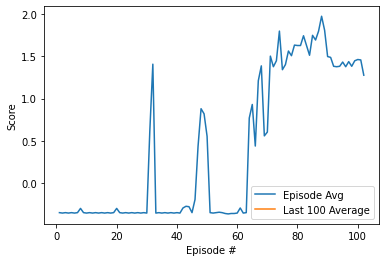

In [4]:
scores_global, average_global, max_global, min_global, time_taken = ddpg(agent, memory, max_num_episodes)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.plot(np.arange(1, len(average_global)+1), average_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Episode Avg', 'Last 100 Average'], loc='lower right')
plt.show()


env.close()